## PREPROCESSING DATA

[Source](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data)

[sentiment-analysis-on-movie-reviews]

In [2]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()

In [3]:
api.authenticate()

In [4]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','test.tsv.zip', path='.data/')
api.competition_download_file('sentiment-analysis-on-movie-reviews','train.tsv.zip',path='.data/')

100%|██████████| 494k/494k [00:01<00:00, 302kB/s]


100%|██████████| 1.28M/1.28M [00:02<00:00, 618kB/s]

In [5]:
import zipfile

In [6]:
with zipfile.ZipFile('data/test.tsv.zip','r') as f:
    f.extractall('data/')
    
with zipfile.ZipFile('data/train.tsv.zip','r') as f:
    f.extractall('data/')

#### Reading the data

In [7]:
import pandas as pd
df = pd.read_csv('data/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The same sentence is copied multiple times, and all copies or duplicates has the same sentence id

In [9]:
print(f"The length of the dataframe is {len(df)}")
print(f"And the number of unique sentences are {len(df['SentenceId'].unique())}")

The length of the dataframe is 156060
And the number of unique sentences are 8529


<Axes: ylabel='Sentiment'>

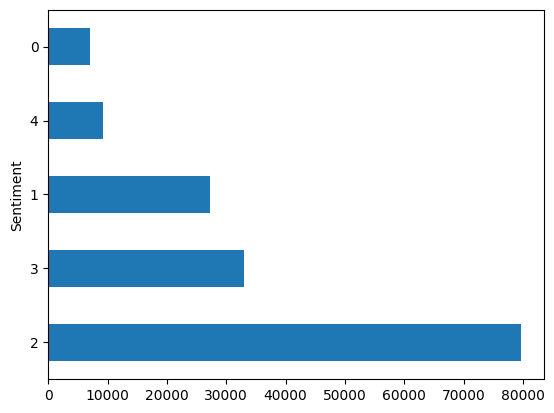

In [10]:
df['Sentiment'].value_counts().plot(kind='barh')

The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [11]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [12]:
from transformers import BertTokenizer

c:\Users\lmbmo\Personal\Project\Sentiment-analysis-with-Transformers\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

c:\Users\lmbmo\Personal\Project\Sentiment-analysis-with-Transformers\venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lmbmo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,truncation = True, padding='max_length', add_special_tokens=True, return_tensors='np') # the special tokens are specific to BERT

In [15]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [17]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [18]:
#saving it as a numpy binary file
import numpy as np
with open('data/movie-xids.npy','wb') as f:
    np.save(f, tokens['input_ids'])
with open('data/movie-xmask.npy','wb') as f:
    np.save(f, tokens['attention_mask'])

In [19]:
arr = df['Sentiment'].values

In [20]:
arr.shape

(156060,)

In [21]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [22]:
arr.max() + 1

5

In [23]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [24]:
labels[np.arange(num_samples), arr] = 1

In [25]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [26]:
with open('data/movies_labels.npy', 'wb') as f:
    np.save(f, labels)

## INPUT PIPELINE

In [27]:
import numpy as np

In [28]:
with open('data/movie-xids.npy','rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('data/movie-xmask.npy','rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('data/movies_labels.npy','rb') as f:
    labels = np.load(f, allow_pickle=True)

In [29]:
Xids.shape

(156060, 512)

In [30]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [31]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [32]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# {input_ids, attention_mask}, outputs 

def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids,
            'attention_mask': masks}, labels

In [34]:
dataset = dataset.map(map_func)

In [35]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
batch_size = 16

In [37]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [38]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [39]:
split = 0.9

In [40]:
size = int((Xids.shape[0]/batch_size)*split)

In [41]:
train_ds = dataset.take(size)
vals_ds = dataset.skip(size)

In [42]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(vals_ds, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [43]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [44]:
train_ds.element_spec == vals_ds.element_spec

True

In [45]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [46]:
ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## BUILD AND TRAIN

In [47]:
from transformers import TFAutoModel

In [48]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [49]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [50]:
import tensorflow as tf

In [51]:
#two inputs
input_ids = tf.keras.layers.Input(shape=512,name='input_ids',dtype='int32')
mask = tf.keras.layers.Input(shape=(512,),name='attention_mask',dtype='int32')

#transformers
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

#classifier_head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='ouputs')(x)

In [52]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [54]:
# bert is the second layer and because we dont want to train a model
# with over 100 million params, we will be setting trainable = False 
model.layers[2].trainable=False

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [56]:
from tensorflow.keras.optimizers import legacy
# importing the legacy version of adam optimizer 
# because decay has been depriciated in newer tf versions
optimizer = legacy.Adam(learning_rate=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [57]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(16,5), dtype=tf.float64, name=None))

In [58]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val',element_spec=element_spec)

In [59]:
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [61]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 1)

8778/8778 [==============================] - 142728s 16s/step - loss: 1.1118 - accuracy: 0.5536 - val_loss: 1.0904 - val_accuracy: 0.5599


In [62]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


### load and predict


In [63]:
model = tf.keras.models.load_model('sentiment_model')

In [66]:
# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [67]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [68]:
probs = model.predict(prep_data("hello world"))[0]

probs

1/1 [==============================] - 5s 5s/step


array([0.04399589, 0.08582212, 0.51696914, 0.32357597, 0.02963688],
      dtype=float32)

In [69]:
import numpy as np

np.argmax(probs)

2

So we have made a test prediction, but we want to be applying this to real phrases from test.tsv. We will load the data into a dataframe, remove fragment duplicates based on SentenceId, then iterate through the list and create a new sentiment column.

In [71]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('data/test.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [72]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


Now we initialize our new sentiment column, and begin making predictions.

In [73]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

1/1 [==============================] - 1s 625ms/step


,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,3
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",3
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,3
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",3


In [75]:
df.tail()

,PhraseId,SentenceId,Phrase,Sentiment
66220,222281,11851,Not sweet enough to liven up its predictable story and will leave even fans of hip-hop sorely disappointed .,1
66239,222300,11852,"Nasty , ugly , pointless and depressing , even if you hate clowns .",1
66253,222314,11853,"With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises .",3
66280,222341,11854,They should have called it Gutterball .,1
66287,222348,11855,"A long-winded , predictable scenario .",1
